In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
#to access kaggle datasets
!pip install --upgrade kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.9)


In [20]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#data scaling
from sklearn.preprocessing import StandardScaler
#data visualization
import matplotlib.pyplot as plt

In [21]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [22]:
#list competitions
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        150           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        184           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        308           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2286           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      17592           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4548           False  
connectx

In [24]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

100% 2.27G/2.27G [00:29<00:00, 29.9MB/s]
100% 2.27G/2.27G [00:29<00:00, 81.9MB/s]


In [28]:


#unzip training data for usage, will take about 5 minutes (its big)
!ls
!unzip LANL-Earthquake-Prediction.zip
!ls

gdrive	LANL-Earthquake-Prediction.zip	sample_data
Archive:  LANL-Earthquake-Prediction.zip
  inflating: sample_submission.csv   
  inflating: test/seg_00030f.csv     
  inflating: test/seg_0012b5.csv     
  inflating: test/seg_00184e.csv     
  inflating: test/seg_003339.csv     
  inflating: test/seg_0042cc.csv     
  inflating: test/seg_004314.csv     
  inflating: test/seg_004cd2.csv     
  inflating: test/seg_004ee5.csv     
  inflating: test/seg_004f1f.csv     
  inflating: test/seg_00648a.csv     
  inflating: test/seg_006e4a.csv     
  inflating: test/seg_007a37.csv     
  inflating: test/seg_00a37e.csv     
  inflating: test/seg_00be11.csv     
  inflating: test/seg_00c35b.csv     
  inflating: test/seg_00cc91.csv     
  inflating: test/seg_00e5f7.csv     
  inflating: test/seg_00f3b9.csv     
  inflating: test/seg_010eab.csv     
  inflating: test/seg_0125d9.csv     
  inflating: test/seg_0144cb.csv     
  inflating: test/seg_0165c6.csv     
  inflating: test/seg_016913.csv   

In [31]:
#Extract training data into a dataframe for further manipulation
train_df = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [32]:
#print first 10 entries
train_df.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


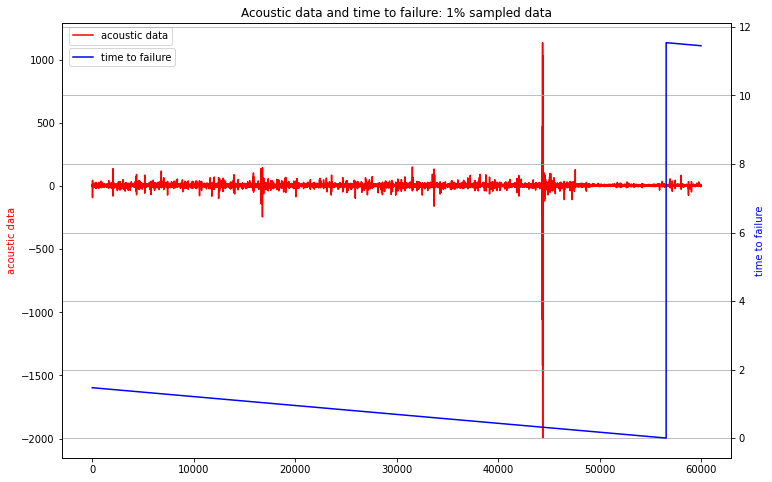

In [33]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [34]:
# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)


In [35]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [36]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


In [37]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,4.884113,5.101106,-98.0,104.0,33.662481,-0.024061,-8.0,-2.0,11.0,18.0,104.0,5.576567,4.333325
1,4.725767,6.588824,-154.0,181.0,98.758517,0.390561,-11.0,-2.0,12.0,21.0,181.0,5.734167,5.732777
2,4.906393,6.967397,-106.0,140.0,33.555211,0.217391,-15.0,-3.0,13.0,26.0,140.0,6.152647,5.895945
3,4.902240,6.922305,-199.0,197.0,116.548172,0.757278,-12.0,-2.0,12.0,22.0,199.0,5.933960,6.061214
4,4.908720,7.301110,-126.0,145.0,52.977905,0.064531,-15.0,-2.0,12.0,26.0,145.0,6.110587,6.329485


In [38]:
y_train.head()

0    1.430797
0    1.391499
0    1.353196
0    1.313798
0    1.274400
dtype: float64